### Данные о клиентах банка:

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

### Данные, связанные с последним контактом:

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

### Прочие признаки:

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

### Целевой признак:

- deposit.

In [65]:


import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import colors
import seaborn as sns
import plotly.express as px
from  sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score  
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
import optuna

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


# Очистка признаков

Посчитаем количество пропусков в наших признаках

In [3]:
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

Мы видим, что явные пропуски есть только в признаке Balance (25), но необходимо понять, есть ли не явные пропуски в других признаках

In [4]:
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes
5,42,management,single,tertiary,no,0 $,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes
6,56,management,married,tertiary,no,"830,00 $",yes,yes,unknown,6,may,1201,1,-1,0,unknown,yes
7,60,retired,divorced,secondary,no,"545,00 $",yes,no,unknown,6,may,1030,1,-1,0,unknown,yes
8,37,technician,married,secondary,no,"1,00 $",yes,no,unknown,6,may,608,1,-1,0,unknown,yes
9,28,services,single,secondary,no,NaN,yes,no,unknown,6,may,1297,3,-1,0,unknown,yes


In [5]:
df.job.value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [6]:
df.education.value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

Видно, что неявные пропуски обозначаются словом unknown. Прежде чем работать с пропусками, приведем сначала данные в признака balance к формату float (сейчас это object)

In [7]:
df['balance'] = df['balance'].replace('\$','', regex=True).replace(" ",'', regex=True).replace(',','.', regex=True).astype(float)

df['balance'][0] #проверим, что преобразования удались

2343.0

И заполним пропуски медианным значением столба balance

In [8]:
df.loc[(df['balance'].isnull() == True), 'balance'] = df['balance'].median()

Проверим, что все пропуски заполнились

In [9]:
df['balance'].isnull().sum()

0

Настало время заполнить неочевидные пропуски для столбов job и education (значение unknown). Т.к. это категориальные признаки, для замены я буду использовать моду. 

*Ожидания: в job будет 2636 значений manager, в education 5973 значения secondary.*

In [10]:
df.loc[(df['job'] == 'unknown'), 'job'] = df['job'].mode()[0]
df.loc[(df['education'] == 'unknown'), 'education'] = df['education'].mode()[0]

Проверим, что наши преобразования выполнились верно

In [11]:
df['job'].value_counts()

management       2636
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: job, dtype: int64

In [12]:
df['education'].value_counts()

secondary    5973
tertiary     3689
primary      1500
Name: education, dtype: int64

Проверим признак balance на наличие выбросов с помощь boxplot

<AxesSubplot:xlabel='balance'>

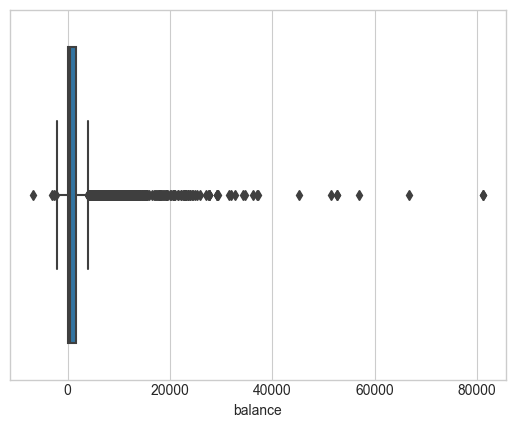

In [13]:
sns.boxplot(x = df['balance'])

На графике видно большое количество выбросов. Воспользуемся методом Тьюки для того, чтобы от них избавиться. (Выброспами будем считать все значения которые отклоняются от Q1 и Q3 на более чем 1.5 межквартильных размаха)

In [14]:
Q1 = np.quantile(df['balance'], .25) #находим 25% квартиль
Q3 = np.quantile(df['balance'], .75) #находим 75% квартиль

IQR = Q3 - Q1 #находим межквартильный размах

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Анализ выбросов меодом Тьюки (нестрогое неравенство)
df_nb = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

Посмотрим, как будет выглядеть наше распределение после преобразования

<AxesSubplot:xlabel='balance'>

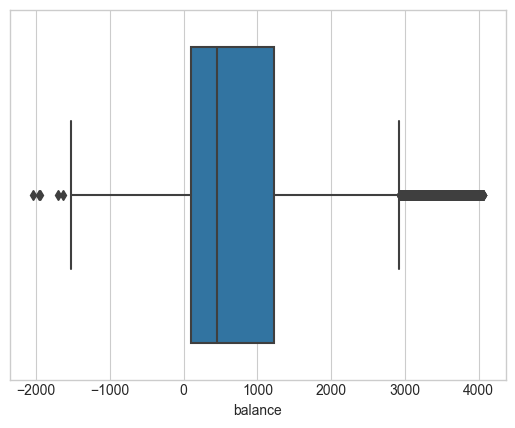

In [15]:
sns.boxplot(x = df_nb['balance'])

In [16]:
df_nb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


In [17]:
#посмотрим сколько значений было удалено
print(f'С помощью метода Тьюки удалось избавиться от {df.shape[0] - df_nb.shape[0]} выбросов')

С помощью метода Тьюки удалось избавиться от 1057 выбросов


# Разведовательный анализ

Посмотрим распределение целевого признака deposit, это будет важно для последующего разделения модели на тестовую и тренировочную выборки (определит необходимость стратификации данных)

In [18]:
df_nb['deposit'].value_counts(normalize= True)

no     0.536764
yes    0.463236
Name: deposit, dtype: float64

Вижно, что признак распределен примерно поровну и стратификация не понадобится

Проведем первичный анализ количественных признаков

In [19]:
df_nb.dtypes

age            int64
job           object
marital       object
education     object
default       object
balance      float64
housing       object
loan          object
contact       object
day            int64
month         object
duration       int64
campaign       int64
pdays          int64
previous       int64
poutcome      object
deposit       object
dtype: object

## Работа с количественными признаками

In [20]:
#выведем колонки которые не являются объектом
num_col = list(df_nb.dtypes[(df_nb.dtypes != 'object')].index) 
num_col

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

Попробуем визуализировать взаимосвязь признаков для поиска зависимостей

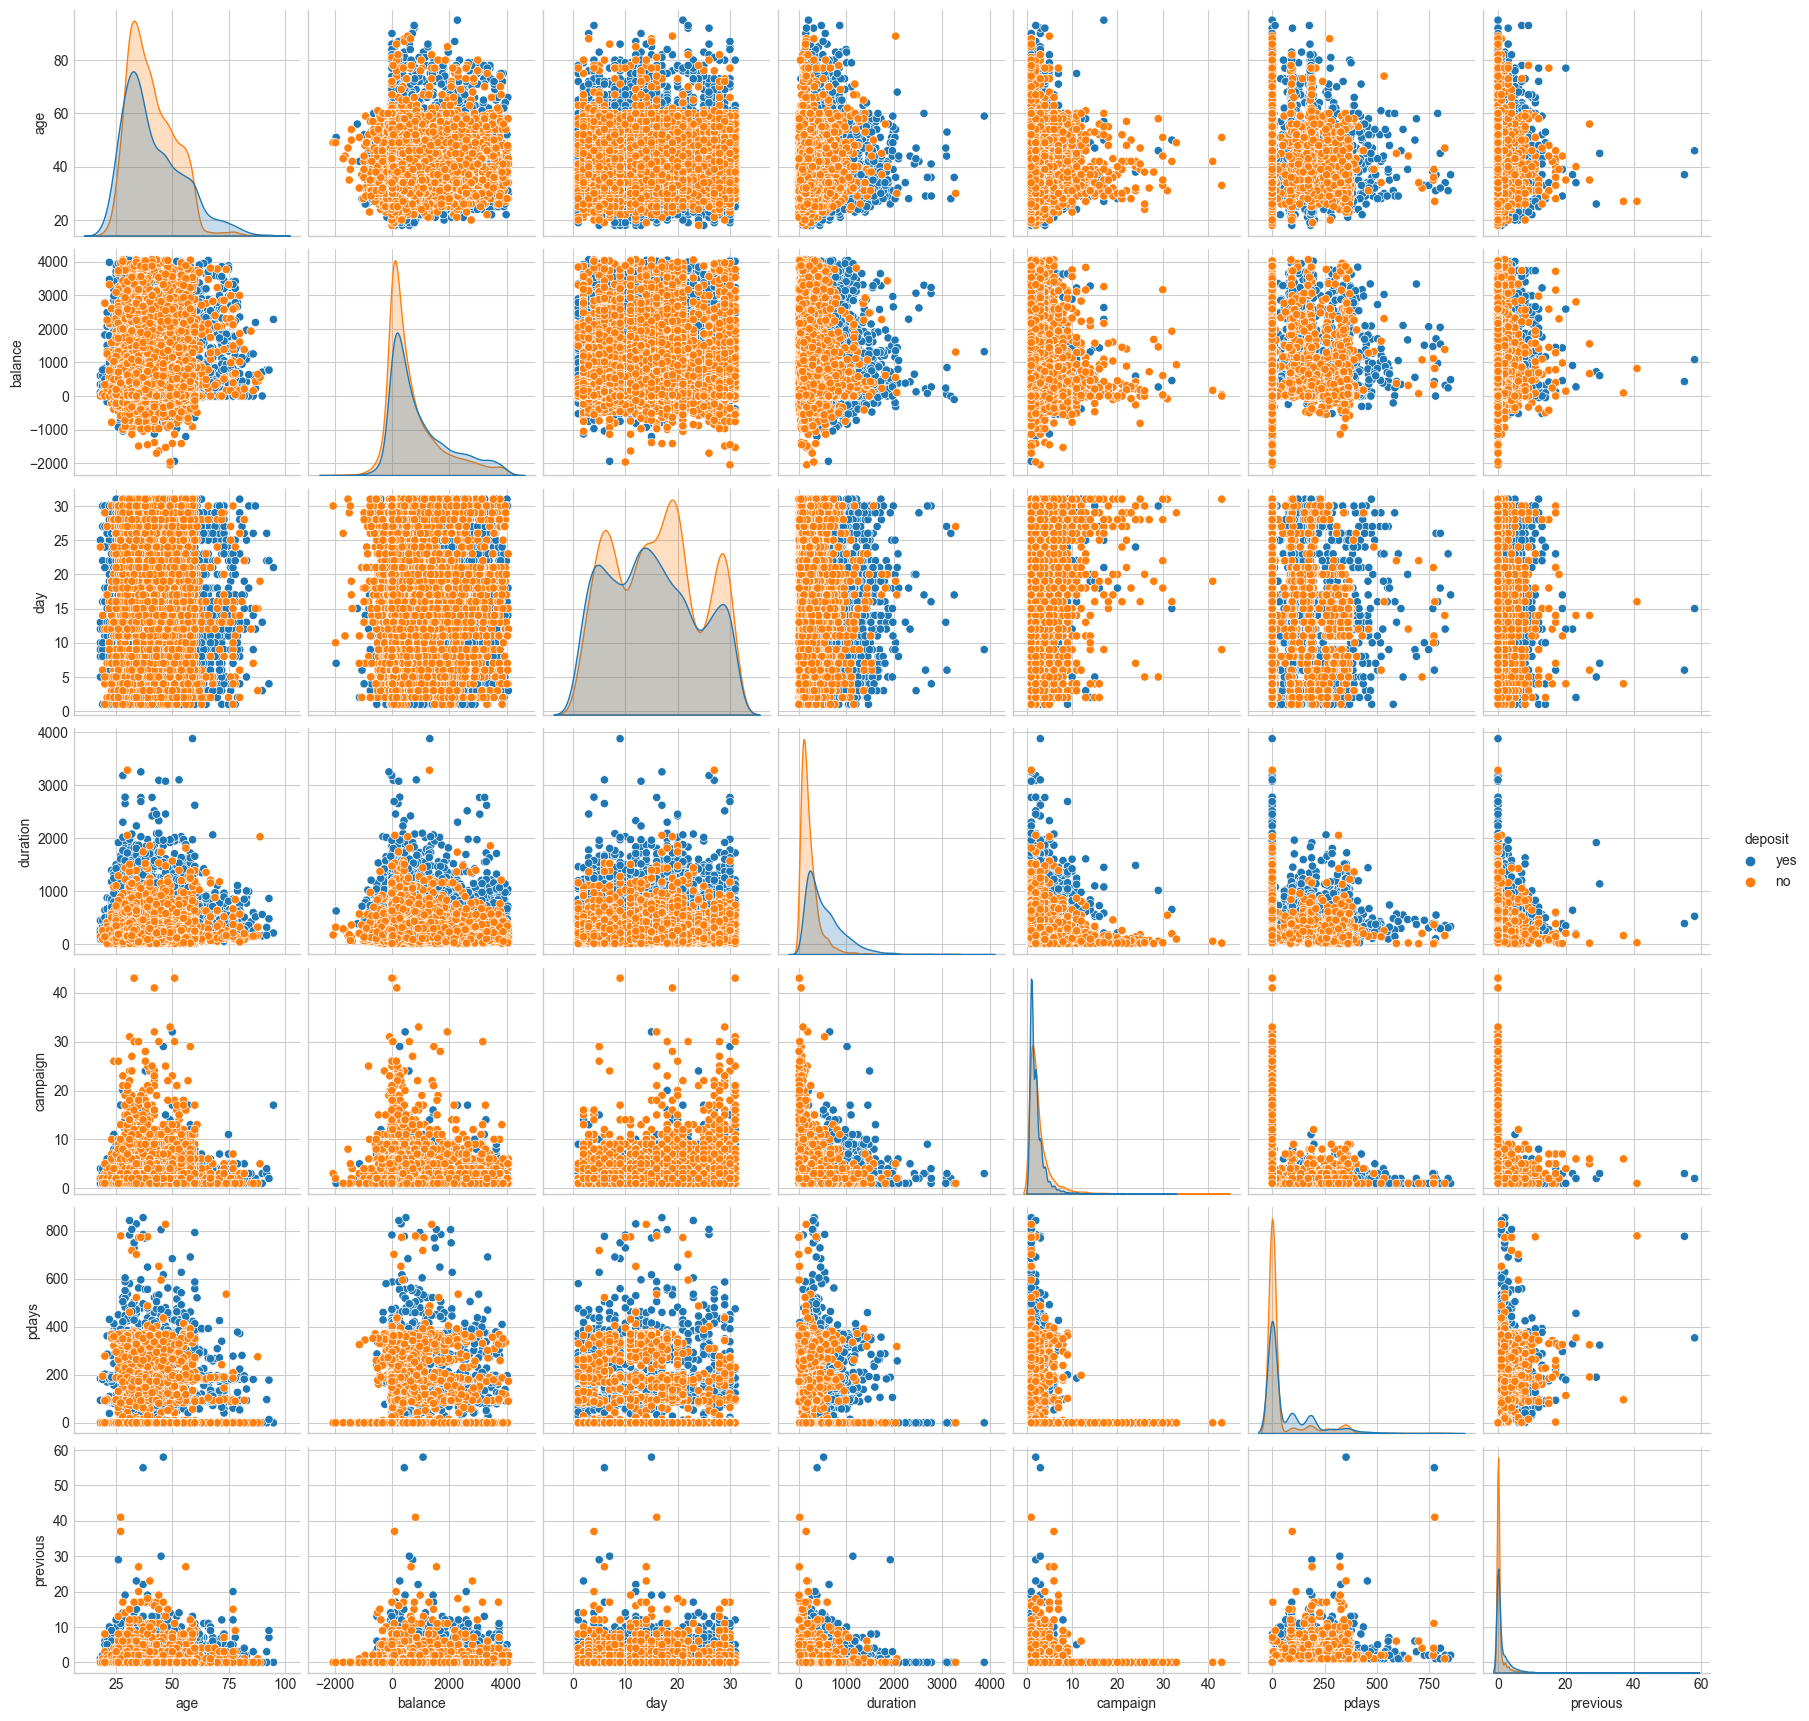

In [21]:
num_col.append('deposit')

sns.pairplot(df_nb[num_col],  hue = 'deposit')

Выводы на основе графиков:

* с увеличением продолжительности контакта растет вероятность, что клиент откровет депозит.
* с клиентами с которыми не было контактов, средняя продолжительность разговора дольше, чем с клиентами с которыми созванивались ранее 

Посмотрим на распределение каждого отдельного признака

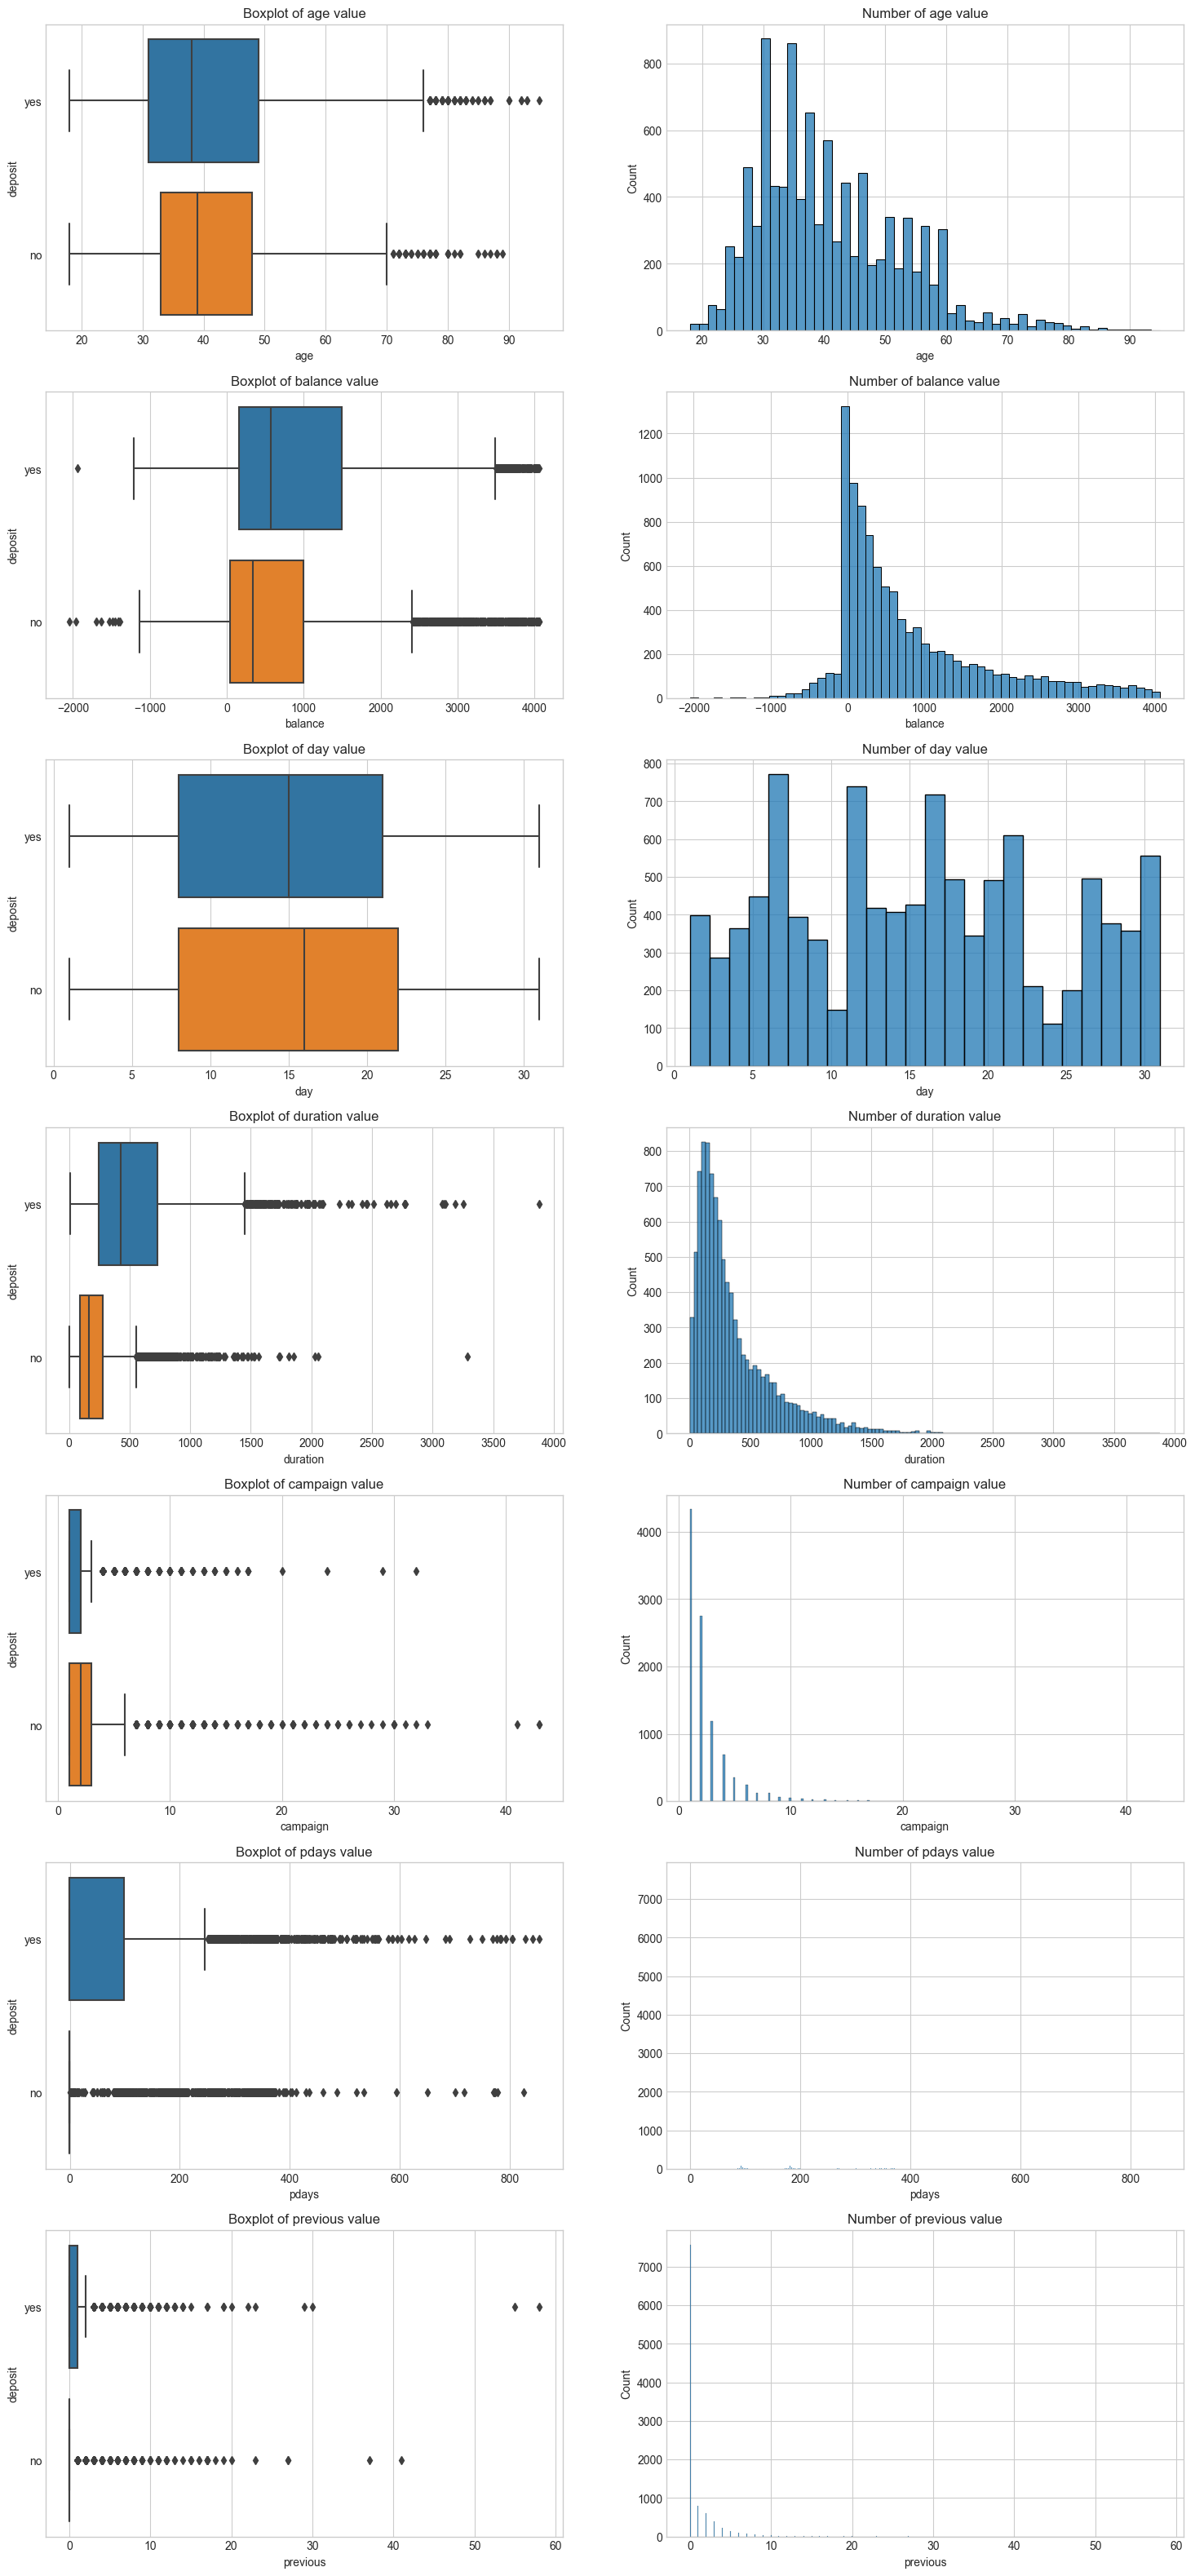

In [22]:
num_col = list(df_nb.dtypes[(df_nb.dtypes != 'object')].index)
fig, ax = plt.subplots(nrows = len(num_col), ncols = 2, figsize = (18,40))

for i, j in enumerate(num_col):
    s1 = sns.boxplot(data = df_nb, x = df_nb[j], y = 'deposit', ax = ax[i][0])
    s1.set_title(f'Boxplot of {j} value')
    s2 = sns.histplot(x = df_nb[j], ax = ax[i][1])
    s2.set_title(f'Number of {j} value')


Из графиков монжо сделать следующие выводы:

1. Возраст:
* Больше всего клиентов в возрасте 30 и 35 лет
* Есть подозрительные выбросы в виде возроста 90+ лет

2. Баланс:
* Большенство клиентов имели 0 на счетах, видимо в компании привлекались в основном новые клиенты

3. Продолжительность:
* Гипотеза о том что клиенты открывшие депозит разговаривали значительно дольше, чем те, кто не открыли депозит
* Подозрительным кажутся значения в районе 4000 секунд

4. Количество контактов с клиентом:
* Большество конткатов не превышает 5, поэтому кажутся подозрительным значения 10+

5. Количество пропущенных дней с момента последней компании
* Большенство отказавшихся находятся в районе значения 0 и выбросы в 100 и более дней кажутся очень подозрительными
* Есть есть значения = 0, кажется подозрительным что каким-то клиентам не звонили год


## Категориальные признаки

In [23]:
#сформируем список категориальных признаков
cat_col = list(df_nb.dtypes[(df_nb.dtypes == 'object')].index)

cat_col

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'deposit']

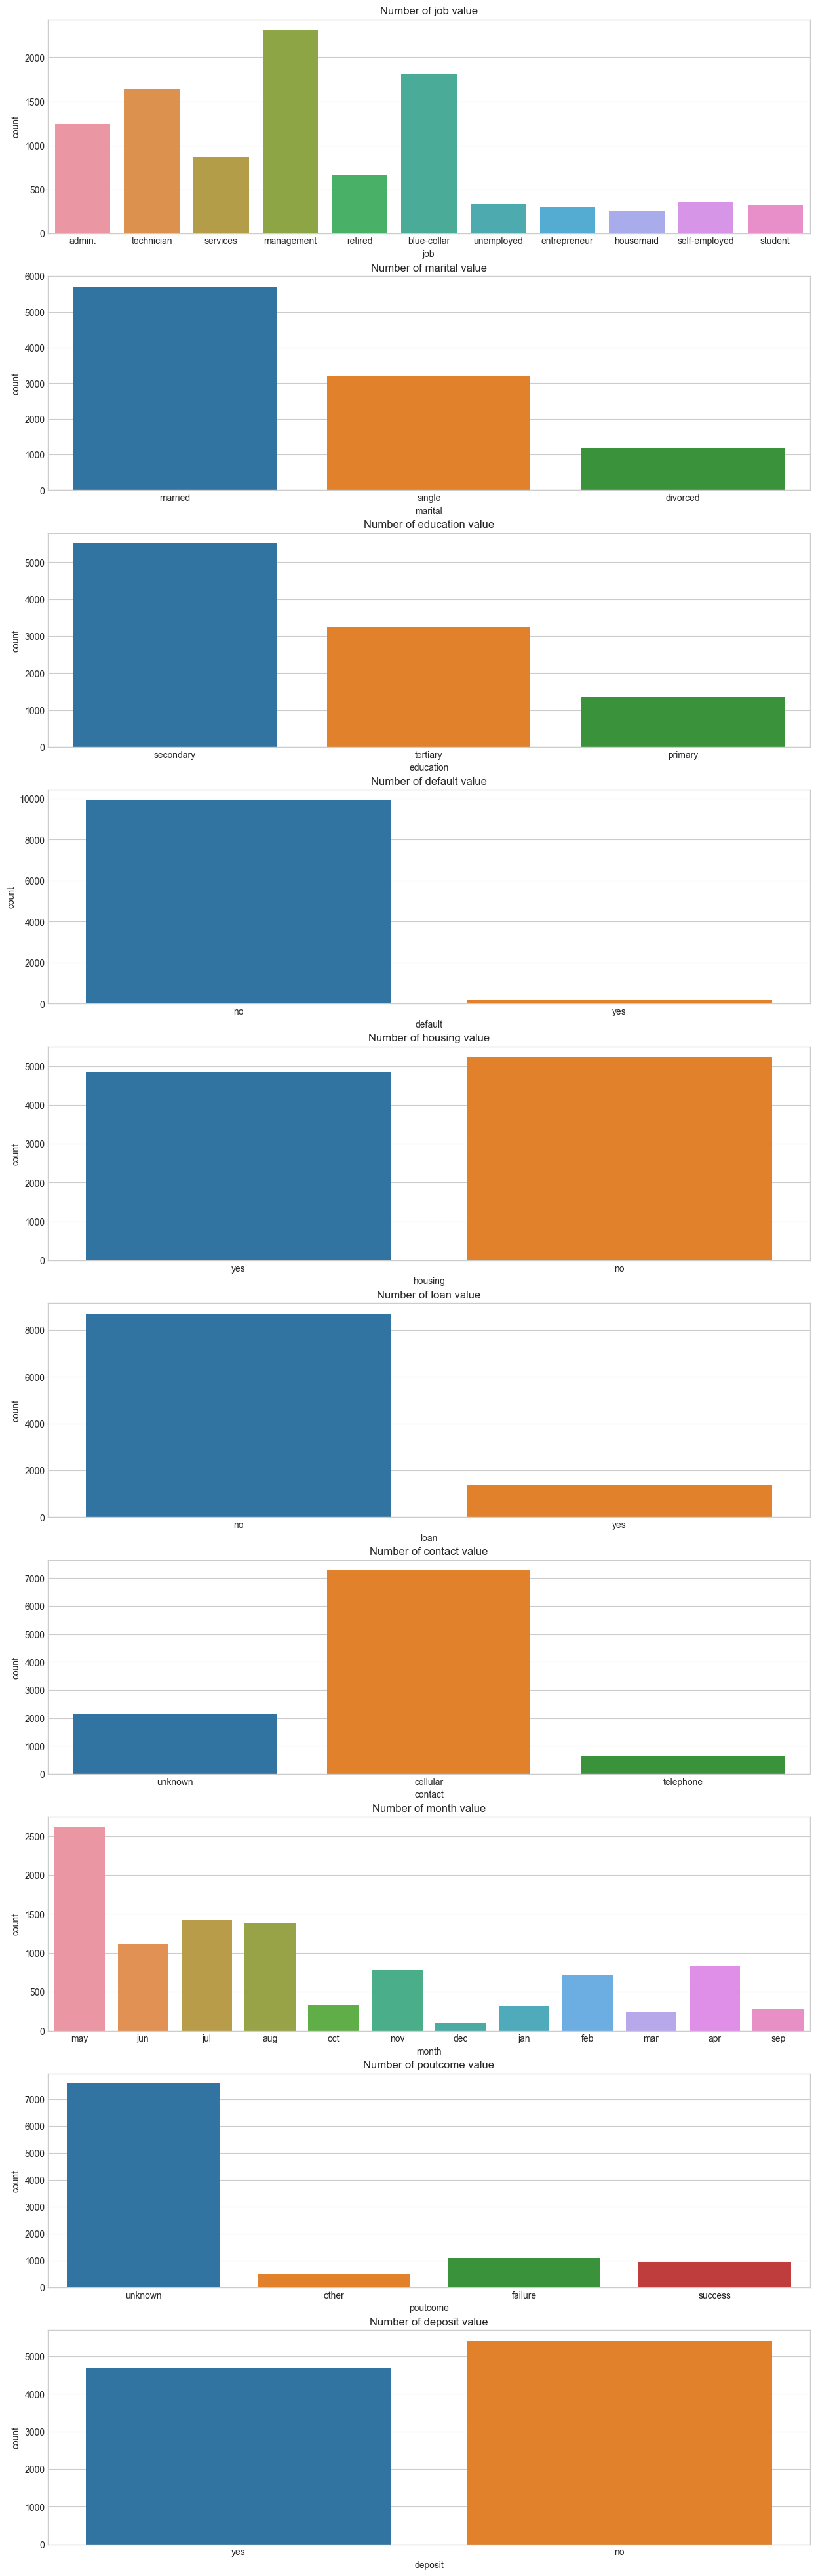

In [24]:
fig, ax = plt.subplots(nrows = len(cat_col), ncols = 1, figsize = (15,50))
for i, j in enumerate(cat_col):
    s1 = sns.countplot(data = df_nb, x = df_nb[j], ax = ax[i])
    s1.set_title(f'Number of {j} value')

Из графиков категориальных признаков видно:

* У среди клиентов представлено 11 сфер деятельности в основном Менеджеры, Синии воротнички и техники
* Большенство клиентов замужем/женаты
* Большенство имеют уровень образования Secondary
* Почти ни у кого нет просроченного кредита
* Мало у кого есть потребительский кредит, а редит на жильё больше чем у половины
* Почти все клиенты предпочитают связываться по мобильному телефону
* Активнее всего с клиентами связывались в Мая, меньше всего в декабре и марте. Возможно потому что финансовый год закончился в апреле и в марте все закрывали отчеты, а в декабре традиционно все уходили в отпуск
* Отсутствик у большенство клиентов данных о результатах прошлой компании говорили или о том, что они не участвовали в ней или о качестве сбора данных

Посмотрим распределение категориальных признаков в зависимости от целевого

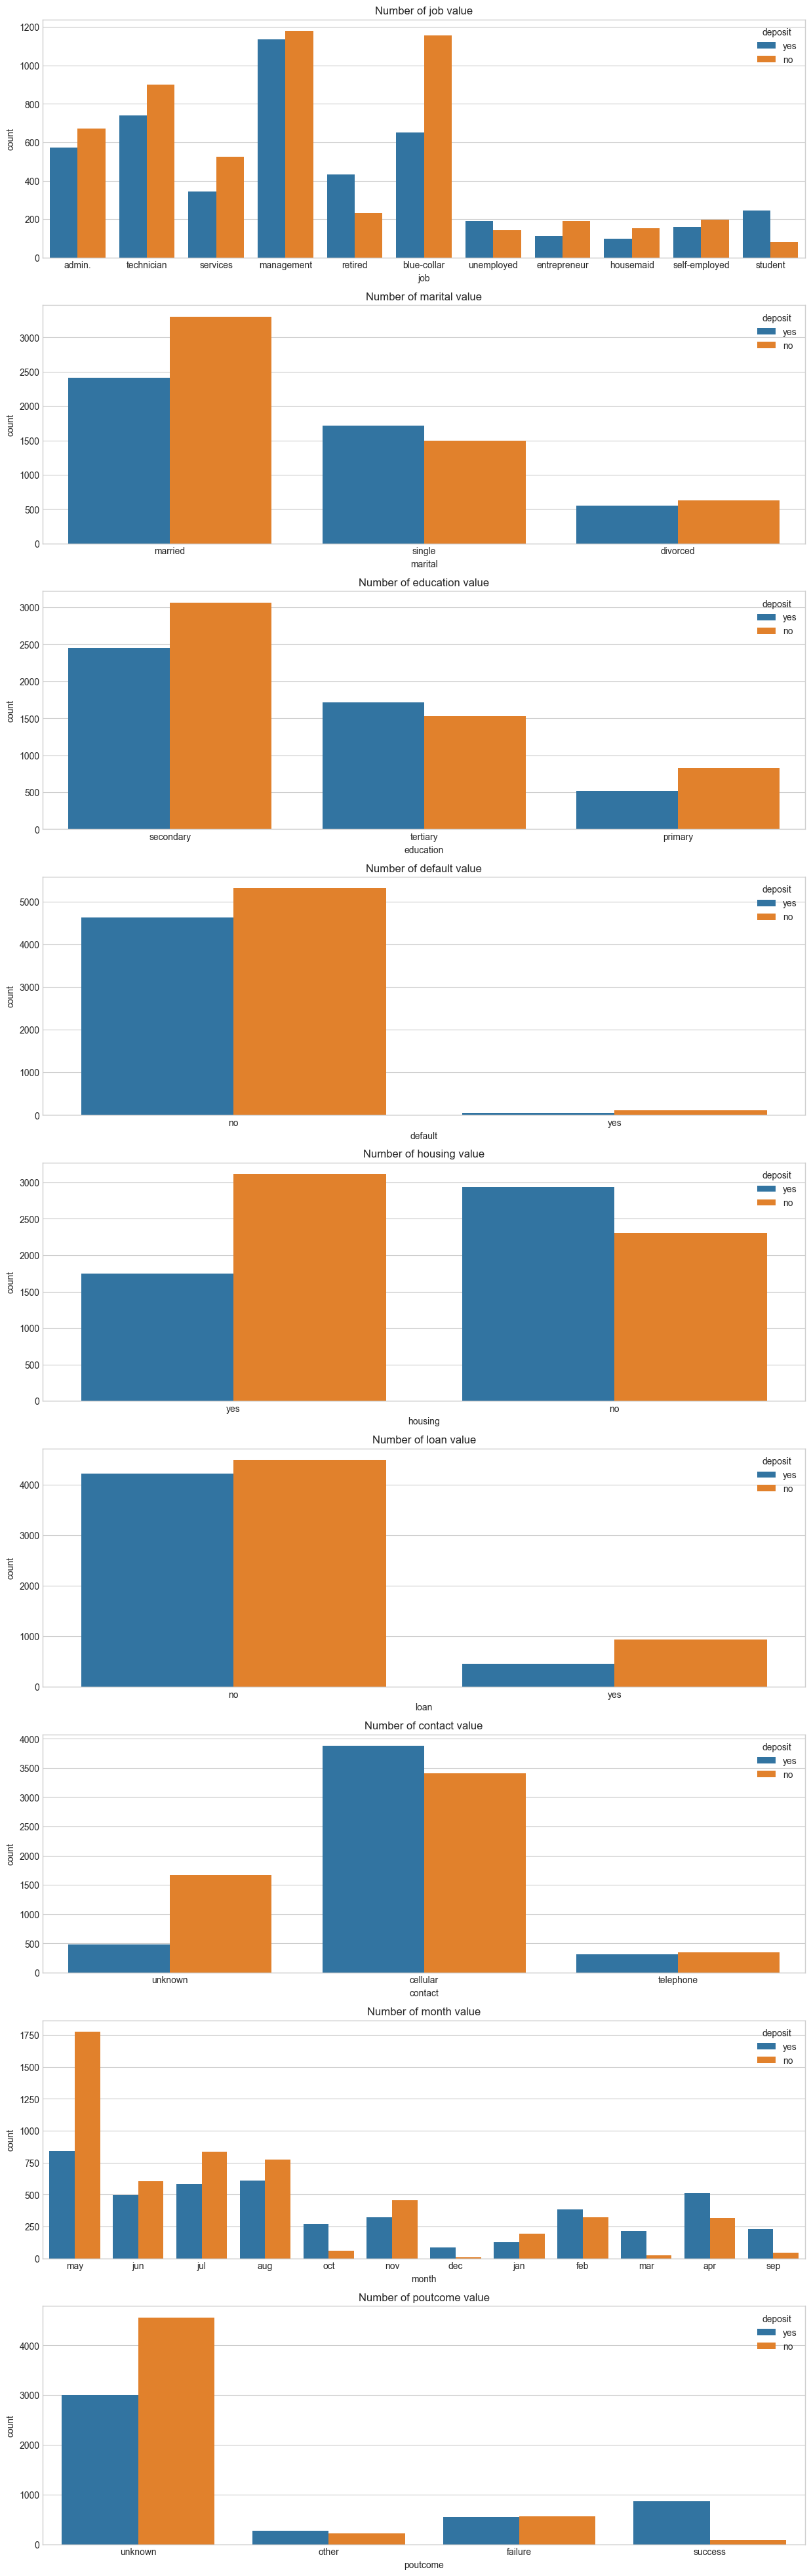

In [25]:
cat_col.remove('deposit')

fig, ax = plt.subplots(nrows = len(cat_col), ncols = 1, figsize = (15,50))
for i, j in enumerate(cat_col):
    s1 = sns.countplot(data = df_nb, x = df_nb[j], hue = 'deposit', ax = ax[i])
    s1.set_title(f'Number of {j} value')

Выводы на основе графиков выше:

* Успешнее всего (для открывших депозит) компания прошла среди студентов и пенсионеров
* Доля открывших депозит среди людей без Ипотеки выше чем с ипотекой при этом наличие потребительского кредита не так сильно сказалось
* Чаще дугих открывали депозит одинокие люди (возможно это соотносится с успехом среди студентов и пенсионеров)
* Люди с мобильными телефонами чаще открывали депозит
* Доля открывших депозит выше всего с декабря по апрель и в сентября, хуже всего в Мае
* Люди которые успешно участвовали в прошлой компании намного чаше открывали депозит

Также хорошей практикой считается шрупировать возраст, т.к. группы проще анализировать

<AxesSubplot:xlabel='age_group', ylabel='count'>

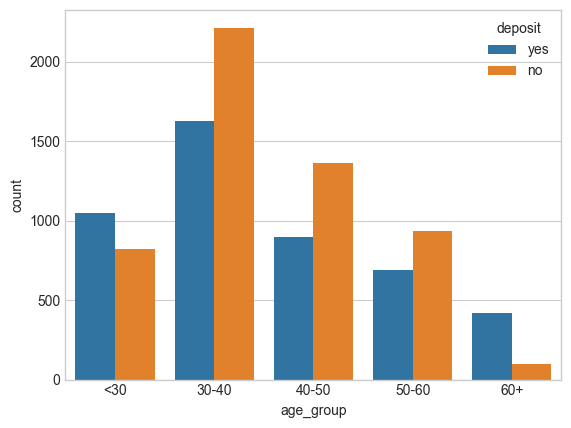

In [26]:
# Для создания категорий используем метод cut()

df_nb['age_group'] = pd.cut(df_nb.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x="age_group", hue="deposit", data=df_nb)

На основе группировки мы видим, что компания успешнее проходит среди людей до 30 лет и после 60, что отлично коррелилрует с успехом среди студентов и пенсионеров, о котором мы говорили ранее

## Отбор и преобразование признаков

Настало время преобразовывать категориальные признаки в числовые, т.к. модель умеет считать, но ей тяжело даётся чтение и анализ текста (никак не даётся).

Но сначала сделаем копию дата-сета с которой будем работать дальше, чтобы был backup

In [27]:
df_enc = df_nb.copy()

df_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        10105 non-null  int64   
 1   job        10105 non-null  object  
 2   marital    10105 non-null  object  
 3   education  10105 non-null  object  
 4   default    10105 non-null  object  
 5   balance    10105 non-null  float64 
 6   housing    10105 non-null  object  
 7   loan       10105 non-null  object  
 8   contact    10105 non-null  object  
 9   day        10105 non-null  int64   
 10  month      10105 non-null  object  
 11  duration   10105 non-null  int64   
 12  campaign   10105 non-null  int64   
 13  pdays      10105 non-null  int64   
 14  previous   10105 non-null  int64   
 15  poutcome   10105 non-null  object  
 16  deposit    10105 non-null  object  
 17  age_group  10105 non-null  category
dtypes: category(1), float64(1), int64(6), object(10)
memory usage: 1.6

Начнем с признака **education** (уровень образования). У признака 3 вариации, которые можно сравнивать (лучше/хуже или больше/меньше), поэтому логично использовать Порядковое кодирование (LabelEncoding)

In [28]:
encoder = LabelEncoder() #назначим кодировщик

df_enc['education'] = encoder.fit_transform(df_enc['education']) #преобразуем данные

df_enc['education'].value_counts() #выведем количество преобразованных признаков

1    5517
2    3239
0    1349
Name: education, dtype: int64

In [29]:
df_nb['education'].value_counts() #Сравним результат с изначальной выборкой

secondary    5517
tertiary     3239
primary      1349
Name: education, dtype: int64

Мы ранее делали группировку по возрасту. Её тоже можно закодировать через LabelEncoder

In [30]:
encoder = LabelEncoder()

df_enc['age_group'] = encoder.fit_transform(df_enc['age_group'])

df_enc['age_group'].value_counts()


0    3842
1    2255
4    1870
2    1625
3     513
Name: age_group, dtype: int64

In [31]:
df_nb['age_group'].value_counts()

30-40    3842
40-50    2255
<30      1870
50-60    1625
60+       513
Name: age_group, dtype: int64

Поработаем с целевой переменной **deposit**, она может принимать всего 2 значения yes/no, а это значит что она бинарная, а бинарную переменную мы будем преобразовывать через Двоичное кодирование

In [32]:
encoder = LabelBinarizer()

df_enc['deposit'] = encoder.fit_transform(df_enc['deposit'])

df_enc['deposit'].value_counts()

0    5424
1    4681
Name: deposit, dtype: int64

In [33]:
df_nb['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

In [34]:
display(df_enc['deposit'].value_counts().to_frame())
display(df_nb['deposit'].value_counts().to_frame())

,deposit
0,5424
1,4681


,deposit
no,5424
yes,4681


Чтобы не перекодировать бинарные признаки по 1, закодируем их через цикл

In [35]:
bin_col = ['default','housing','loan'] #список колонок с бинарным признаком
encoder = LabelBinarizer() #Настройка кодировщика

#создаем цикл перебора 3 колонок для преобразования
for i in bin_col: 
    
    df_enc[i] = encoder.fit_transform(df_enc[i]) 
    
    #Отображаем количество признаков до и после преобразования, для проверики
    display(df_enc[i].value_counts().to_frame()) 
    display(df_nb[i].value_counts().to_frame())

,default
0,9939
1,166


,default
no,9939
yes,166


,housing
0,5243
1,4862


,housing
no,5243
yes,4862


,loan
0,8712
1,1393


,loan
no,8712
yes,1393


Преобразуем оставшиеся признаки через Get dummies

In [36]:
ohe_col = ['job','marital','contact','month','poutcome'] #cоздадим лист с категориальными признаками для OneHot кодирования

col_count1 = df_enc.shape[1] #Определим количество столбцов ДО преобразования, для сравнения 

df_enc = pd.get_dummies(df_enc, columns= ohe_col)

col_count2 = df_enc.shape[1]+5 #Определим количество столбцов ПОСЛЕ преобразования, для сравнения (+5 т.к. будут удалены изначальные колонки)

print(f'Было добавлено {col_count2 - col_count1} колонок')

print(df_enc.columns)

Было добавлено 33 колонок
Index(['age', 'education', 'default', 'balance', 'housing', 'loan', 'day',
       'duration', 'campaign', 'pdays', 'previous', 'deposit', 'age_group',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


Теперь когда все признаки стали чистовыми, мы можем оценить корреляцию между ними. Будем использовать стандартную функцию corr() и оценивать корреляцию Спирмана. Она хорошо отображает только линейные зависимости

<AxesSubplot:>

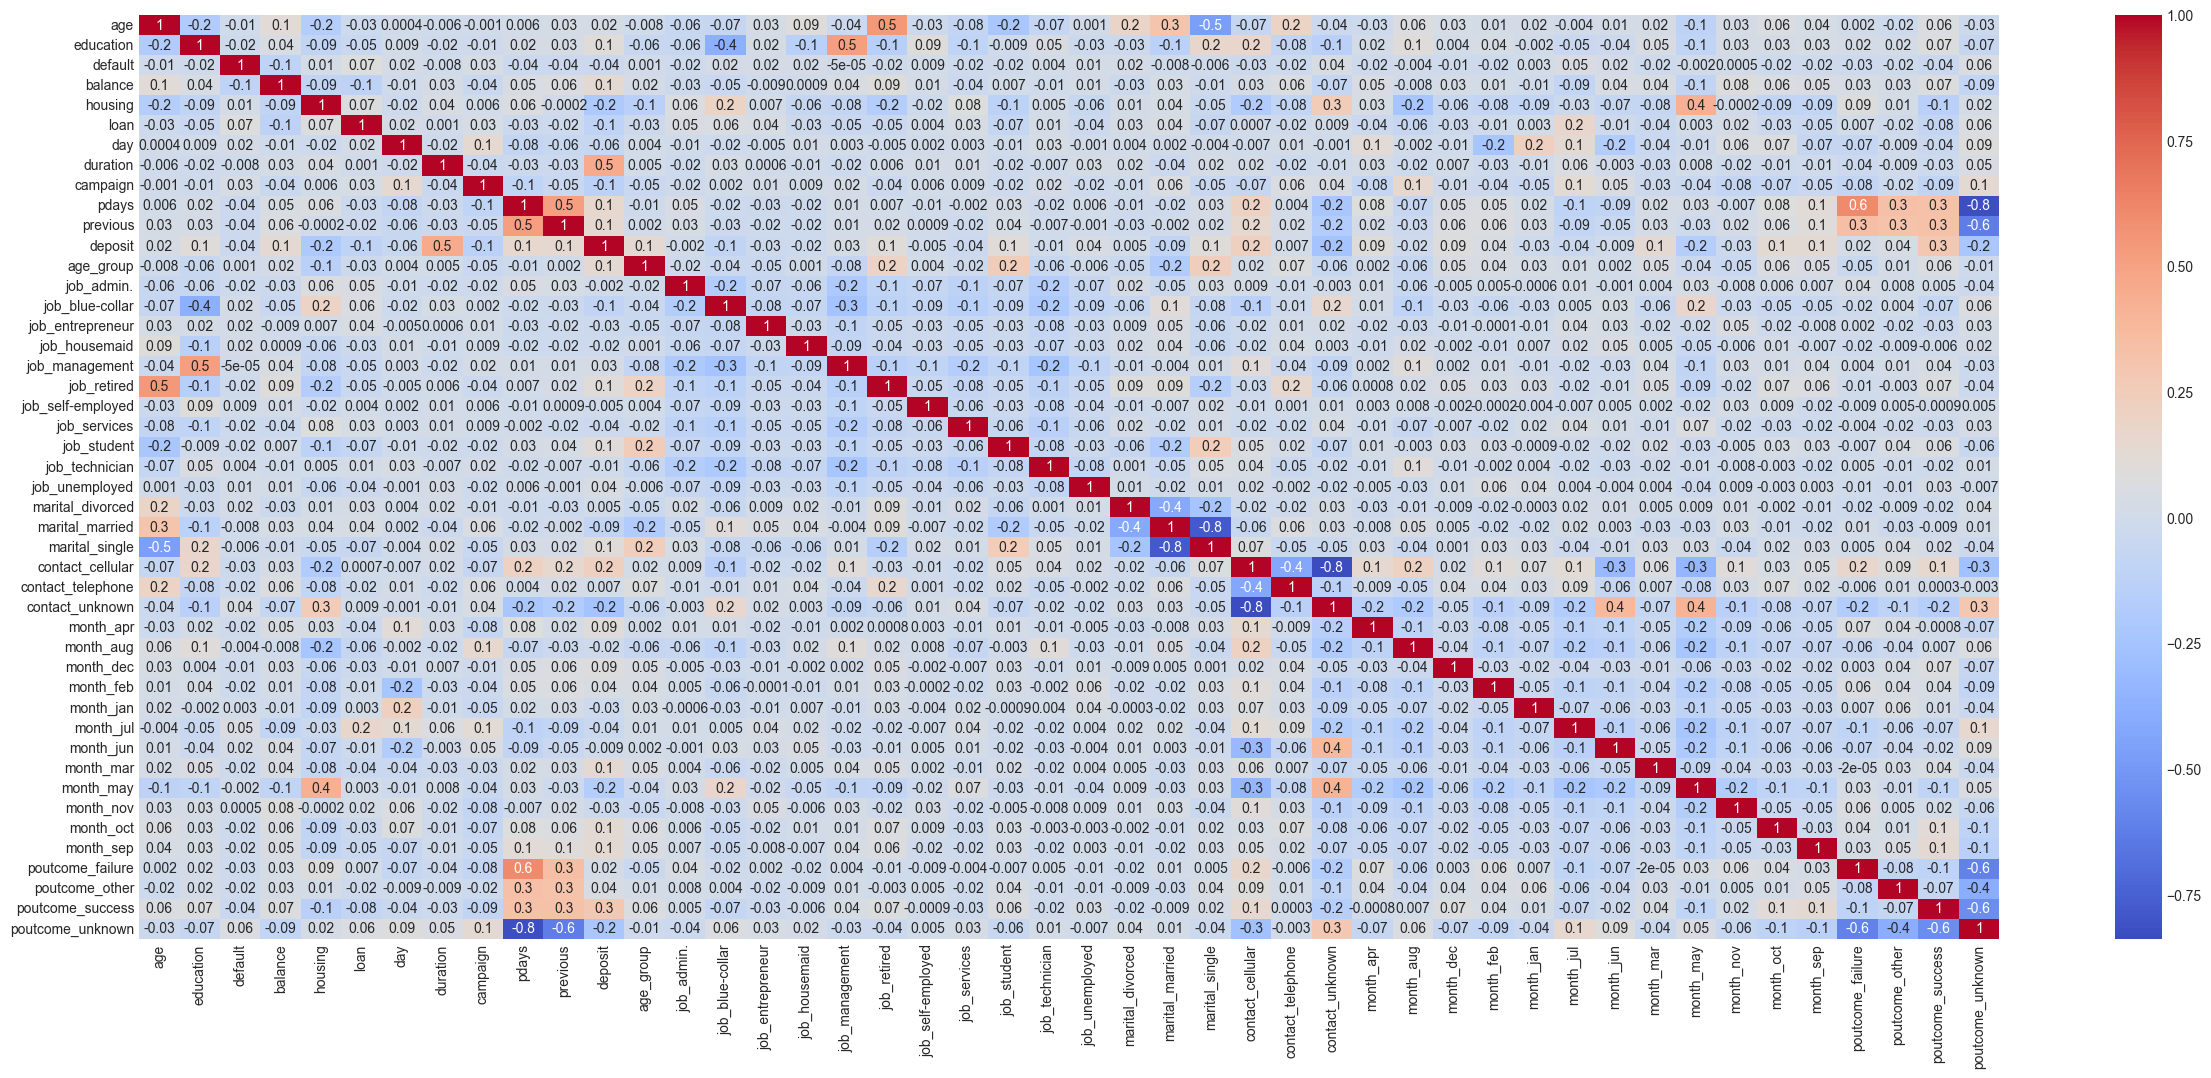

In [37]:
plt.figure(figsize=(30,12))
sns.heatmap(df_enc.corr(), annot=True, fmt='.1g', cmap = 'coolwarm')

Мы видим что сильнее всего с целевой переменной коррелируют признаки:

* Duration (0.5)
* poutcome_success (0.3)
* contact_cellular (0.2)
* poutcome_unknown (-0.2)

Так же есть взаимоисключающие признаки с высоким отрицательным коэффициентом корреляции:

* single/married
* данные с меткой unknown

И есть интерересная зависимость между Проваленой прошлой компанией и количество дней с момента последней компанией до звонка

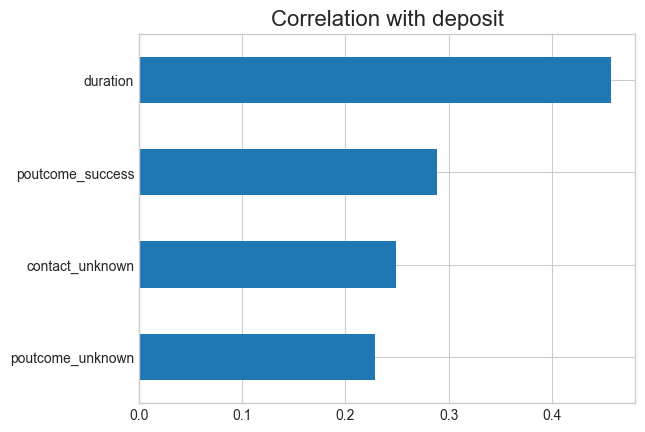

In [38]:
#для удобства отображения корреляций сделаем график
corr = df_enc.corr()

corr["deposit"].apply(lambda x: abs(x)).sort_values()[-5:-1].plot.barh()
plt.title("Correlation with deposit", fontsize = 16)
plt.show()

In [39]:
df_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int32  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int32  
 5   loan               10105 non-null  int32  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int32  
 12  age_group          10105 non-null  int32  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

Мы преобразовали все категориальные признаки и настало время подготавливать данные для моделирования.

Сначала разобьём наши данные на целевую переменную (y) и предикаторы (X)

In [40]:
y = df_enc['deposit']
X = df_enc.drop('deposit', axis = 1)

# выведем размеры таблиц для проверки корректности разделения
print(df_enc.shape)
print(y.shape)
print(X.shape)

(10105, 46)
(10105,)
(10105, 45)


Теперь наши выборки надо разделить на тренировочную и тестовую

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33, stratify=y)

Поскольку у нас много (45) предикатов, имеет смысл сократить их количество и оставить те, которые сильнее остальных связаны с целевой переменной. Для этого воспользуемся методом SelectKBest

In [42]:
select_k_best_classifier = SelectKBest(score_func = f_classif, k = 15).fit(X_train, y_train) #Определяем лучшие показатели

mask = select_k_best_classifier.get_support(indices=True) #Определяем позиции наилучших показателей
best_features = X_train.columns[mask] #Находим названия колонок

X_train_k = X_train[best_features] #Формируем новый датафрейм
X_test_k = X_test[best_features]

X_train_k.shape

(6770, 15)

Давайте посмотрим на 15 наших силачей

In [43]:
X_train_k.columns

Index(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

А теперь надо сделать скейлинг данных, чтобы они все имели одинаковую размерность

In [44]:

min_max_scaller = preprocessing.MinMaxScaler()

min_max_scaller.fit(X_train_k)

X_train_scaled = min_max_scaller.transform(X_train_k)
X_test_scaled = min_max_scaller.transform(X_test_k)

#X_train_scaled = pd.DataFrame(X_train_scaled, columns=best_features)
#X_test_scaled = pd.DataFrame(X_test_scaled, columns=best_features)

# Решение задачи классификации: логистическая регрессия и решающие деревья

Настало время строить модели!

## Baseline

### Логистическая регрессия

In [51]:

lr_base = linear_model.LogisticRegression(solver = 'sag', random_state= 42, max_iter=1000)

lr_base.fit(X_train_scaled, y_train)

y_pred_lr_base_train = lr_base.predict(X_train_scaled)
y_pred_lr_base_test = lr_base.predict(X_test_scaled)

display('Значение accuracy(train) логистической регресии для baseline: {:.2f}'.format(metrics.accuracy_score(y_train, y_pred_lr_base_train)))
display('Значение accuracy(test) логистической регресии для baseline: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred_lr_base_test)))
display('Значение F1-score(test) логистической регресии для baseline: {:.2f}'.format(metrics.f1_score(y_test, y_pred_lr_base_test)))

'Значение accuracy(train) логистической регресии для baseline: 0.82'

'Значение accuracy(test) логистической регресии для baseline: 0.81'

'Значение F1-score(test) логистической регресии для baseline: 0.78'

### Решающие деревья

In [46]:
dt_base = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)

dt_base.fit(X_train_scaled, y_train)

y_pred_dt_base_train = dt_base.predict(X_train_scaled)
y_pred_dt_base_test = dt_base.predict(X_test_scaled)

display('Значение accuracy(train) Решающих деревьев для baseline: {:.2f}'.format(metrics.accuracy_score(y_train, y_pred_dt_base_train)))
display('Значение accuracy(test) Решающих деревьев для baseline: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred_dt_base_test)))

'Значение accuracy(train) Решающих деревьев для baseline: 1.00'

'Значение accuracy(test) Решающих деревьев для baseline: 0.75'

Из метрик видно, что модель переобучена. Мы можем перебором глубины добиться оптимального значения для Accuracy на тренировочной и тестовой выборках

,Train,Test,Depth
5,0.82,0.81,6
6,0.84,0.81,7
7,0.84,0.81,8
8,0.85,0.81,9


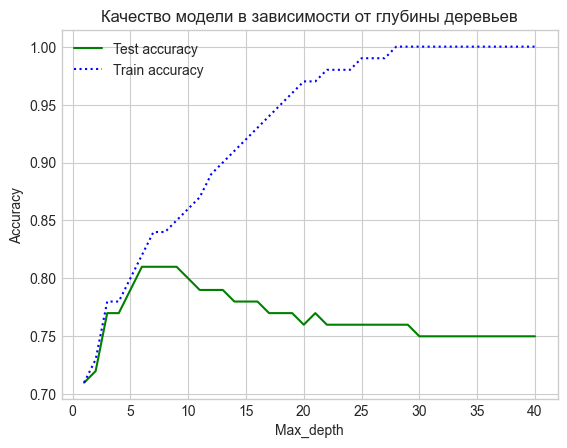

In [47]:
data = [] #создаем лист для сбора значений

for i in range(1, 41):
    
    dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=i)
    dt.fit(X_train_scaled, y_train)
    y_pred_dt_train = dt.predict(X_train_scaled)
    y_pred_dt_test = dt.predict(X_test_scaled)
    
    list = [round(metrics.accuracy_score(y_train, y_pred_dt_train),2), round(metrics.accuracy_score(y_test, y_pred_dt_test),2), i]
    
    data.append(list)

    #display('Значение accuracy(train) {:.2f}, Значение accuracy(test) {:.2f}, Глубина {}'.format(metrics.accuracy_score(y_train, y_pred_dt_train), metrics.accuracy_score(y_test, y_pred_dt_test), i))

dt_df = pd.DataFrame(data, columns=['Train','Test','Depth'])

#Визуализируем результат

fig = plt.figure()
ax = plt.axes()
plt.title("Качество модели в зависимости от глубины деревьев")
plt.xlabel("Max_depth")
plt.ylabel("Accuracy")
plt.plot(dt_df['Depth'], dt_df['Test'], '-g', label='Test accuracy')
plt.plot(dt_df['Depth'], dt_df['Train'], ':b', label='Train accuracy')


plt.legend()

display(dt_df[dt_df['Test'] == dt_df['Test'].max()])


Видно, что мы получаем максимальный показатель Test accuracy при глубине от 6 до 9, но на 6 глубине, модель менее переобученная, чем на 7-9. Попробуем высчитать f1-score с глубиной 6

In [54]:
dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)
dt.fit(X_train_scaled, y_train)
y_pred_dt_train = dt.predict(X_train_scaled)
y_pred_dt_test = dt.predict(X_test_scaled)

display('Значение f1-score(test) Решающих деревьев для baseline: {:.2f}'.format(metrics.f1_score(y_test, y_pred_dt_test)))

'Значение f1-score(test) Решающих деревьев для baseline: 0.80'

Разумеется, у каждой модели может быть множество параметров. Перебирать их вручную, чтобы получить наилучшее качество, долго и трудозатратно. Поэтому мы можем использовать оптимизацию: можно перебрать сразу большое количество комбинаций различных параметров и выбрать тот вариант, при котором модель будет давать наиболее точный прогноз. И для этого у нас есть GridSearch

## GridSearch

In [48]:
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth':[3,5,7]
}

grid_dt = GridSearchCV(
    estimator = tree.DecisionTreeClassifier(random_state=42),
    param_grid = param_grid,
    n_jobs= -1,
    scoring = 'f1' 
)

%time grid_dt.fit(X_train_scaled, y_train)

y_pred_grid = grid_dt.predict(X_test_scaled)

print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_pred_grid)))
print("Наилучшие значения гиперпараметров: {}".format(grid_dt.best_params_))

CPU times: total: 250 ms
Wall time: 3 s
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


# Решение задачи классификации: ансамбли моделей и построение прогноза

## Случайный лес

In [49]:
rf = ensemble.RandomForestClassifier(n_estimators = 100,
criterion = 'gini',
min_samples_leaf = 5,
max_depth = 10,
random_state = 42)

rf.fit(X_train_scaled, y_train)

y_pred_rf = rf.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



| Model | Accuracy | F1-score |
| :- | -: | :-: |
| Logistic Regression | 0.81 | 0.78 
| Decision Tree | 0.81 | 0.80
| GridSearch | - | 0.80
| Random Forest | 0.83 | 0.83

Попробуем еще улучшить наш показатель F1-score и воспользуемся градиентным бустингом

## Градиентный бустинг

In [56]:
gb = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)

gb.fit(X_train_scaled, y_train)

y_pred_gb = gb.predict(X_test_scaled)

display('Значение f1-score(test) для Градиентного бустинга: {:.2f}'.format(metrics.f1_score(y_test, y_pred_gb)))

'Значение f1-score(test) для Градиентного бустинга: 0.82'

| Model | Accuracy | F1-score |
| :- | -: | :-: |
| Logistic Regression | 0.81 | 0.78 
| Decision Tree | 0.81 | 0.80
| GridSearch | - | 0.80
| Random Forest | - | 0.83
| Gradient boosting | - | 0.82

Градиентный бустинг не смог улучшить результаты случайного леса. Еще 1 метод, который может помочь нам в задачи улучшения предсказания - стекинг

## Стекинг

In [57]:
estimators = [
    ('dt',tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
     
    ('gb',ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
    )
    ),
    
    ('lr', linear_model.LogisticRegression(
        solver = 'sag', 
        random_state= 42, 
        max_iter=1000)
     )
    
]

stack = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator= linear_model.LogisticRegression(random_state=42)
)

stack.fit(X_train_scaled, y_train)

y_pred_stack = stack.predict(X_test_scaled)

display('Значение f1-score(test) для Стекинга: {:.2f}'.format(metrics.f1_score(y_test, y_pred_stack)))

'Значение f1-score(test) для Стекинга: 0.81'

Не знаю как вы, а я ожидал большего от силы дружбы 4 моделей

| Model | Accuracy | F1-score |
| :- | -: | :-: |
| Logistic Regression | 0.81 | 0.78 
| Decision Tree | 0.81 | 0.80
| GridSearch | - | 0.80
| Random Forest | - | 0.83
| Gradient boosting | - | 0.82
| Stacking | - | 0.81

Раз количество моделей победить не удалось, попробуем выйграть за счет качества, а именно попробуем улучшить гиперпараметры с помощью Optuna

## Optuna

In [63]:
def optuna_rf(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf
    )
    
    model.fit(X_train_scaled, y_train)
    
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
    
    return score

In [66]:
%%time

study = optuna.create_study(study_name='RandomForestClassification', direction='maximize')

study.optimize(optuna_rf, n_trials= 50)

[I 2022-10-20 12:06:15,658] A new study created in memory with name: RandomForestClassification
[I 2022-10-20 12:06:22,953] Trial 0 finished with value: 0.8208316645328237 and parameters: {'n_estimators': 117, 'max_depth': 28, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8208316645328237.
[I 2022-10-20 12:06:27,040] Trial 1 finished with value: 0.8206595218430307 and parameters: {'n_estimators': 147, 'max_depth': 15, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8208316645328237.
[I 2022-10-20 12:06:30,275] Trial 2 finished with value: 0.8199929972015418 and parameters: {'n_estimators': 105, 'max_depth': 16, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8208316645328237.
[I 2022-10-20 12:06:32,326] Trial 3 finished with value: 0.8199710023494513 and parameters: {'n_estimators': 128, 'max_depth': 20, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8208316645328237.
[I 2022-10-20 12:06:35,121] Trial 4 finished with value: 0.8266663619248107 and parameter

CPU times: total: 1min 9s
Wall time: 2min 31s


In [67]:
study.best_params

{'n_estimators': 189, 'max_depth': 22, 'min_samples_leaf': 5}

In [71]:
model = ensemble.RandomForestClassifier(**study.best_params)

model.fit(X_train_scaled, y_train)

y_pred_optuna_rf = model.predict(X_test_scaled)

f1_optuna_rf = metrics.f1_score(y_test, y_pred_optuna_rf)
print('F1-score на Optuna для Случайного леса равен {:.2f}'.format(f1_optuna_rf))

F1-score на Optuna для Случайного леса равен 0.82


In [72]:
print(metrics.classification_report(y_test, y_pred_optuna_rf))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Поробуем сделать Стекинг с параметрами леса от Optuna

In [73]:
estimators = [
    ('rf',ensemble.RandomForestClassifier(
        criterion='gini',
        min_samples_leaf=5,
        max_depth=22,
        n_estimators = 189,
        random_state=42
        )
    ),
     
    ('gb',ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
    )
    ),
    
    ('lr', linear_model.LogisticRegression(
        solver = 'sag', 
        random_state= 42, 
        max_iter=1000)
     )
    
]

stack = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator= linear_model.LogisticRegression(random_state=42)
)

stack.fit(X_train_scaled, y_train)

y_pred_stack = stack.predict(X_test_scaled)

display('Значение f1-score(test) для Стекинга: {:.2f}'.format(metrics.f1_score(y_test, y_pred_stack)))

'Значение f1-score(test) для Стекинга: 0.81'

Этого было недостаточно, попробуем подобрать параметры для Логистической регрессии и Бустинга

In [76]:
def optuna_gb(trial):
    
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1)
    max_depth = trial.suggest_int('max_depth', 3, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    model = ensemble.GradientBoostingClassifier(
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        n_estimators = 300
    )
    
    model.fit(X_train_scaled, y_train)
    
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
    
    return score

In [77]:
%%time

study = optuna.create_study(study_name='GradientBoosting', direction='maximize')

study.optimize(optuna_gb, n_trials= 50)

[I 2022-10-20 13:03:18,990] A new study created in memory with name: GradientBoosting
[I 2022-10-20 13:03:46,268] Trial 0 finished with value: 0.791854529715016 and parameters: {'learning_rate': 0.7422336010850531, 'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.791854529715016.
[I 2022-10-20 13:03:55,102] Trial 1 finished with value: 0.8151797159204651 and parameters: {'learning_rate': 0.177350073307897, 'max_depth': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8151797159204651.
[I 2022-10-20 13:04:13,904] Trial 2 finished with value: 0.7873050903157748 and parameters: {'learning_rate': 0.7703158753270567, 'max_depth': 7, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8151797159204651.
[I 2022-10-20 13:04:32,645] Trial 3 finished with value: 0.7931330659008171 and parameters: {'learning_rate': 0.542441409293933, 'max_depth': 8, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8151797159204651.
[I 2022-10-20 13:04:48,672] Trial 4 finishe

CPU times: total: 10min 2s
Wall time: 20min 24s
